# Neural Translation: Infix to Postfix Notation

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., `a + b`), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
`a + b * c`

This expression can be parsed in two different ways:

| Interpretation (Infix) | Equivalent Postfix |
| ---------------------- | ------------------ |
| `(a + b) * c`          | `a b + c *`        |
| `a + (b * c)`          | `a b c * +`        |

This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach. To control the complexity, we restrict our dataset to formulae with a **maximum syntactic depth of 3** and require that all binary operations are **fully parenthesized**, like `(e1 op e2)`.

## 1. Setup and Imports

First, we import the necessary libraries. We'll use `numpy` for numerical operations, `tensorflow` and `keras` for building and training the model, `matplotlib` for plotting, and `random` for data generation.

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-07 11:20:46.638289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 11:20:46.642220: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 11:20:46.656102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749288046.675730   10220 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749288046.682364   10220 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749288046.697892   10220 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### 1.1 Download the model

In [2]:
import gdown
!gdown 1ocOwpYn0xYQwXIbPDIudi8gNTt3RbFKZ

Downloading...
From: https://drive.google.com/uc?id=1ocOwpYn0xYQwXIbPDIudi8gNTt3RbFKZ
To: /home/giorgio/Desktop/DL/NoLoad/exam/full_model.keras
100%|██████████████████████████████████████| 5.39M/5.39M [00:00<00:00, 22.8MB/s]


## 2. Constants and Vocabulary

We define the vocabulary for our expressions. This includes identifiers (`a, b, c, d, e`), operators (`+, -, *, /`), parentheses, and special tokens for sequence processing: `PAD` (padding), `SOS` (start of sequence), and `EOS` (end of sequence).

In [3]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK']

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH - 2
MODEL_FILE = "full_model.keras"

print("="*60)
print("INFIX TO POSTFIX NEURAL NETWORK TRANSLATION")
print("="*60)
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Maximum sequence length: {MAX_LEN}")
print(f"Vocabulary: {VOCAB}")

INFIX TO POSTFIX NEURAL NETWORK TRANSLATION
Vocabulary size: 15
Maximum sequence length: 30
Vocabulary: ['PAD', 'SOS', 'EOS', '(', ')', '+', '-', '*', '/', 'a', 'b', 'c', 'd', 'e', 'JUNK']


## 3. Data Generation and Preprocessing

Here we define the functions to generate our dataset.
- `generate_infix_expression`: Recursively creates fully parenthesized infix expressions up to a specified depth.
- `tokenize`: Splits an expression string into a list of tokens.
- `infix_to_postfix`: Converts a tokenized infix expression to its postfix equivalent using a standard stack-based algorithm.
- `encode`: Converts a list of tokens into a sequence of integer IDs, adding `EOS` and padding to `MAX_LEN`.
- `decode_sequence`: Reverts a sequence of IDs back to a human-readable string.
- `generate_dataset`: Creates a complete dataset of (infix, postfix) pairs.
- `shift_right`: Prepares the decoder input for teacher forcing by prepending the `SOS` token.

In [4]:
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n, max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(max_depth)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

### Dataset Inspection

Let's generate a sample dataset and inspect a few examples to ensure our functions are working correctly. We'll look at the original infix expression, the target postfix expression, and the shifted decoder input used for teacher forcing.

In [5]:
# Generate a sample dataset
X_demo, Y_demo = generate_dataset(5)
decoder_input_demo = shift_right(Y_demo)

# Inspect a random sample
i =  np.random.randint(5)
print(f"--- Sample {i} ---")
print("Infix         : ", decode_sequence(X_demo[i], id_to_token))
print("Postfix (Target): ", decode_sequence(Y_demo[i], id_to_token))
print("Decoder Input   : ", decode_sequence(decoder_input_demo[i], id_to_token))

--- Sample 3 ---
Infix         :  ( ( a + d ) * ( d * a ) )
Postfix (Target):  a d + d a * *
Decoder Input   :  SOS a d + d a * *


## 4. Model Architecture

### Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).
* The maximum number of parameters is **2 million**.
* Beam search is not allowed for generation.

We will use an **Encoder-Decoder** architecture with LSTMs.

- **Encoder**: A Bidirectional LSTM processes the input infix sequence and compresses it into a context vector (the hidden states `h` and `c`). Using a bidirectional LSTM allows the encoder to capture information from both past and future tokens at each step.
- **Decoder**: An LSTM uses the encoder's final context vector as its initial state. It then generates the output postfix sequence one token at a time. The decoder's input at each step is the previously generated token (for inference) or the ground-truth token (for training via teacher forcing).
- **Parameter Efficiency**: To stay under the 2 million parameter limit, we use a single Bidirectional LSTM in the encoder and a single LSTM in the decoder with moderate hidden dimensions. Dropout is applied to prevent overfitting.

In [6]:
def create_efficient_encoder_decoder_model(vocab_size=VOCAB_SIZE, max_len=MAX_LEN, embedding_dim=128, hidden_dim=192):
    """
    Encoder-Decoder LSTM model optimized for parameter efficiency
    Target: Under 2M parameters while maintaining strong performance
    """

    # Encoder
    encoder_input = layers.Input(shape=(max_len,), name='encoder_input')
    encoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_input)

    # Single bidirectional LSTM for encoder efficiency
    encoder_lstm = layers.Bidirectional(
        layers.LSTM(hidden_dim//2, return_state=True, dropout=0.2, recurrent_dropout=0.2)
    )(encoder_embedding)

    encoder_outputs = encoder_lstm[0]
    encoder_state_h = layers.Concatenate()([encoder_lstm[1], encoder_lstm[3]])
    encoder_state_c = layers.Concatenate()([encoder_lstm[2], encoder_lstm[4]])
    encoder_states = [encoder_state_h, encoder_state_c]

    # Decoder
    decoder_input = layers.Input(shape=(max_len,), name='decoder_input')
    decoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_input)

    # Single LSTM decoder
    decoder_lstm = layers.LSTM(hidden_dim, return_sequences=True, return_state=True,
                              dropout=0.2, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Output projection
    dense_intermediate = layers.Dense(hidden_dim//2, activation='relu')(decoder_outputs)
    dense_intermediate = layers.Dropout(0.3)(dense_intermediate)
    output = layers.Dense(vocab_size, activation='softmax')(dense_intermediate)

    model = models.Model(inputs=[encoder_input, decoder_input], outputs=output)
    return model

def create_simple_encoder_decoder_v1(vocab_size=VOCAB_SIZE, max_len=MAX_LEN, embedding_dim=64, hidden_dim=128):
    """
    Simplified Version 1: Smaller dimensions, unidirectional encoder
    Target: ~150K parameters
    """
    # Encoder
    encoder_input = layers.Input(shape=(max_len,), name='encoder_input')
    encoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_input)
    
    # Single unidirectional LSTM (instead of bidirectional)
    encoder_lstm = layers.LSTM(hidden_dim, return_state=True, dropout=0.1, recurrent_dropout=0.1)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_input = layers.Input(shape=(max_len,), name='decoder_input')
    decoder_embedding = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_input)
    
    decoder_lstm = layers.LSTM(hidden_dim, return_sequences=True, return_state=True, 
                              dropout=0.1, recurrent_dropout=0.1)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    
    # Simpler output layer
    output = layers.Dense(vocab_size, activation='softmax')(decoder_outputs)
    
    model = models.Model(inputs=[encoder_input, decoder_input], outputs=output)
    return model

def create_minimal_lstm_model(vocab_size=15, max_len=30, embedding_dim=32, hidden_dim=32):
    """
    Minimal LSTM model - single layer encoder-decoder
    Target: ~15K parameters
    """
    # Encoder
    encoder_input = layers.Input(shape=(max_len,), name='encoder_input')
    encoder_embedding = layers.Embedding(vocab_size, embedding_dim)(encoder_input)
    
    encoder_lstm = layers.LSTM(hidden_dim, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_input = layers.Input(shape=(max_len,), name='decoder_input')
    decoder_embedding = layers.Embedding(vocab_size, embedding_dim)(decoder_input)
    
    decoder_lstm = layers.LSTM(hidden_dim, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    
    output = layers.Dense(vocab_size, activation='softmax')(decoder_outputs)
    
    model = models.Model(inputs=[encoder_input, decoder_input], outputs=output)
    return model

## 5. Training Strategy

We define a comprehensive training function that encapsulates dataset generation, model compilation, and the training loop.

- **Model Compilation**: The model is compiled with the `Adam` optimizer, which is a robust choice for NLP tasks. We use `sparse_categorical_crossentropy` as the loss function because our targets are integer-encoded tokens. Gradient clipping (`clipnorm`) is used to stabilize training.
- **Callbacks**:
  - `EarlyStopping`: Halts training if the validation loss does not improve for a set number of epochs (`patience`), and restores the weights from the best epoch.
  - `ReduceLROnPlateau`: Reduces the learning rate when the validation loss plateaus, allowing the model to find a better minimum.

In [7]:
# def create_and_compile_model():
#     """Create and compile the model, ensuring parameter count is under 2M"""
#     model = create_efficient_encoder_decoder_model()

#     param_count = model.count_params()
#     print(f"\nModel parameter count: {param_count:,}")

#     # Compile with appropriate loss and metrics
#     model.compile(
#         optimizer=Adam(learning_rate=0.002, clipnorm=1.0),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

def create_and_compile_model():
    """Create and compile the model, ensuring parameter count is under 2M"""
    model = create_minimal_lstm_model()

    param_count = model.count_params()
    print(f"\nModel parameter count: {param_count:,}")

    # Compile with appropriate loss and metrics
    model.compile(
        optimizer=Adam(learning_rate=0.003, clipnorm=1.0),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_model(train_size=10000, val_size=1000, batch_size=32, epochs=50,
                learning_rate=0.003, clipnorm=1.0, early_stopping_patience=4,
                lr_reduction_factor=0.7, lr_reduction_patience=4, min_lr=1e-6,
                verbose=1):

    # Create separators
    main_separator = "=" * 60
    sub_separator = "-" * 40

    print(f"\n{main_separator}")
    print("TRAINING PHASE")
    print(main_separator)

    print("\nGenerating datasets...")
    print(f"  Training samples: {train_size:,}")
    print(f"  Validation samples: {val_size:,}")

    X_train, Y_train = generate_dataset(train_size)
    decoder_input_train = shift_right(Y_train)

    X_val, Y_val = generate_dataset(val_size)
    decoder_input_val = shift_right(Y_val)

    # Model creation section
    print(f"\n{sub_separator}")
    print("MODEL ARCHITECTURE")
    print(sub_separator)
    model = create_and_compile_model()
    model.summary()

    print(f"\n{sub_separator}")
    print("TRAINING CONFIGURATION")
    print(sub_separator)

    # Create callbacks with configurable parameters
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=verbose
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=lr_reduction_factor,
            patience=lr_reduction_patience,
            min_lr=min_lr,
            verbose=verbose
        )
    ]

    # Display all configuration parameters
    print(f"Optimizer: Adam (lr={learning_rate}, clipnorm={clipnorm})")
    print("Loss function: sparse_categorical_crossentropy")
    print(f"Batch size: {batch_size}")
    print(f"Max epochs: {epochs}")
    print("Callbacks:")
    print(f"  - Early stopping: patience={early_stopping_patience}, monitor=val_loss")
    print(f"  - Learning rate reduction: factor={lr_reduction_factor}, patience={lr_reduction_patience}")
    print(f"  - Minimum learning rate: {min_lr}")

    print(f"\n{sub_separator}")
    print("TRAINING EXECUTION")
    print(sub_separator)

    # Training with all configurable parameters
    history = model.fit(
        [X_train, decoder_input_train], Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([X_val, decoder_input_val], Y_val),
        callbacks=callbacks,
        verbose=verbose
    )

    # Training analysis section
    print(f"\n{sub_separator}")
    print("TRAINING RESULTS")
    print(sub_separator)

    # Extract training metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    epochs_trained = len(history.history['loss'])

    # Display results with improved formatting
    print(f"Training completed after {epochs_trained} epochs")
    print(f"Final training accuracy: {final_train_acc:.4f}")
    print(f"Final validation accuracy: {final_val_acc:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")

    print(f"\nSaving full model to {MODEL_FILE}...")
    model.save(MODEL_FILE)
    print("Model saved successfully.")

    return model, history

## 6. Inference and Evaluation

### Autoregressive Decoding
During inference, we don't have the ground-truth sequence to feed to the decoder. Instead, we must generate the output **autoregressively**:
1.  Feed the `SOS` token as the initial input to the decoder.
2.  Predict the next token in the sequence.
3.  Use this predicted token as the input for the next time step.
4.  Repeat until an `EOS` token is generated or the maximum length is reached.

This is a form of **greedy decoding**, as we always choose the token with the highest probability at each step.

In [8]:
def autoregressive_decode(model, encoder_input, max_length=MAX_LEN):
    """
    Autoregressive generation for an encoder-decoder model.
    """
    encoder_input = np.expand_dims(encoder_input, 0)

    # Initialize decoder input with SOS token
    decoder_input = np.zeros((1, max_length), dtype=np.int32)
    decoder_input[0, 0] = SOS_ID

    for i in range(1, max_length):
        # Get predictions from the model
        predictions = model.predict([encoder_input, decoder_input], verbose=0)

        # Select the next token (greedy decoding)
        next_token_id = np.argmax(predictions[0, i-1, :])

        # Stop if the EOS token is generated
        if next_token_id == EOS_ID:
            break

        # Update the decoder input for the next step
        decoder_input[0, i] = next_token_id

    return decoder_input[0]

### Evaluation Metric: Prefix Accuracy

We evaluate a generated sequence `y_pred` using **prefix accuracy**. This measures the length of the initial prefix of `y_pred` that exactly matches the ground truth `y_true`.

$$ \text{Score} = \frac{\text{Length of matching prefix}}{\max(\text{len}(y_{\text{true}}), \text{len}(y_{\text{pred}}))} $$

This metric is more informative than an exact match (which is often 0) and captures how much of the sequence the model generated correctly before making a mistake.

In [9]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

def test(model, no=20, rounds=10):
    print(f"Evaluating model performance on {no} expressions × {rounds} rounds...")
    rscores = []
    for i in range(rounds):
        print(f"Round {i+1}/{rounds}...")
        X_test, Y_test = generate_dataset(no)
        scores = []
        for j in range(no):
            encoder_input = X_test[j]
            generated = autoregressive_decode(model, encoder_input)[1:]  # remove SOS
            scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
        round_mean = np.mean(scores)
        rscores.append(round_mean)
        print(f"  Round {i+1} accuracy: {round_mean:.4f}")

    final_mean = np.mean(rscores)
    final_std = np.std(rscores)
    print("\nEvaluation complete!")
    print(f"Mean accuracy across all rounds: {final_mean:.4f}")
    print(f"Standard deviation: {final_std:.4f}")

    return final_mean, final_std

## 7. Visualization and Analysis

We'll use these functions to analyze the results.
- `plot_training_history`: Visualizes the training/validation accuracy and loss over epochs.
- `demonstrate_model_performance`: Shows qualitative results by printing the model's predictions on a few random examples and calculating the prefix accuracy score for each.

In [10]:
def plot_training_history(history):

    # Extract history data
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(loss_history, label='Training Loss', linewidth=2, color='blue')
    ax1.plot(val_loss_history, label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Loss During Training', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(acc_history, label='Training Accuracy', linewidth=2, color='green')
    ax2.plot(val_acc_history, label='Validation Accuracy', linewidth=2, color='orange')
    ax2.set_title('Accuracy During Training', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print training summary
    epochs_trained = len(loss_history)
    final_train_loss = loss_history[-1]
    final_val_loss = val_loss_history[-1]
    final_train_acc = acc_history[-1]
    final_val_acc = val_acc_history[-1]
    best_val_acc = max(val_acc_history)

    print(f"\n{'-'*50}")
    print("TRAINING SUMMARY")
    print(f"{'-'*50}")
    print(f"Total epochs trained: {epochs_trained}")
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")
    print(f"Final training accuracy: {final_train_acc:.4f}")
    print(f"Final validation accuracy: {final_val_acc:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

def demonstrate_model_performance(model, num_examples=10):
    print(f"\n{'='*70}")
    print("MODEL PERFORMANCE DEMONSTRATION")
    print(f"{'='*70}")

    X_demo, Y_demo = generate_dataset(num_examples)

    perfect_matches = 0
    partial_matches = 0
    total_score = 0

    print(f"Testing on {num_examples} randomly generated expressions:\n")

    for i in range(num_examples):
        encoder_input = X_demo[i]
        target = Y_demo[i]
        generated = autoregressive_decode(model, encoder_input)[1:]

        infix_str = decode_sequence(encoder_input, id_to_token)
        target_str = decode_sequence(target, id_to_token)
        generated_str = decode_sequence(generated, id_to_token)

        score = prefix_accuracy_single(target, generated, id_to_token)
        total_score += score

        if score == 1.0:
            perfect_matches += 1
            status = "✓ PERFECT"
        elif score > 0.5:
            partial_matches += 1
            status = "~ PARTIAL"
        else:
            status = "✗ POOR"

        print(f"Example {i+1:2d}:")
        print(f"  Input (Infix):     {infix_str}")
        print(f"  Target (Postfix):  {target_str}")
        print(f"  Generated:         {generated_str}")
        print(f"  Score: {score:.3f}  [{status}]")
        print()

    avg_score = total_score / num_examples

    print(f"{'-'*50}")
    print("DEMONSTRATION RESULTS")
    print(f"{'-'*50}")
    print(f"Average score: {avg_score:.3f}")
    print(f"Perfect matches: {perfect_matches}/{num_examples} ({perfect_matches/num_examples*100:.1f}%)")
    print(f"Partial matches: {partial_matches}/{num_examples} ({partial_matches/num_examples*100:.1f}%)")
    print(f"Poor matches: {num_examples - perfect_matches - partial_matches}/{num_examples} ({(num_examples - perfect_matches - partial_matches)/num_examples*100:.1f}%)")

## 8. Main Execution

This is the main block where we tie everything together. It handles:
1.  **Model Loading/Training**: It attempts to load a pre-trained model from `full_model.keras`. If the file doesn't exist (or if `load=False`), it will train a new model from scratch.
2.  **Visualization**: If a new model was trained, it plots the training history.
3.  **Demonstration**: It runs a qualitative demonstration of the model's performance.
4.  **Final Evaluation**: It performs the final, formal evaluation by running the `test` function, which calculates the mean and standard deviation of prefix accuracy over 10 rounds.

To force retraining of the model, set `FORCE_RETRAIN = True`.


Forcing retraining of a new model.

TRAINING PHASE

Generating datasets...
  Training samples: 10,000
  Validation samples: 1,000

----------------------------------------
MODEL ARCHITECTURE
----------------------------------------

Model parameter count: 18,095


2025-06-07 11:20:56.268104: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 32)    │        480 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 30, 32)    │        480 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 32),      │      8,320 │ embedding[0][0]   │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 30, 32)    │      8,320 │ embedding_1[0][0… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 15)    │        495 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,095 (70.68 KB)

 Trainable params: 18,095 (70.68 KB)

 Non-trainable params: 0 (0.00 B)


----------------------------------------
TRAINING CONFIGURATION
----------------------------------------
Optimizer: Adam (lr=0.003, clipnorm=1.0)
Loss function: sparse_categorical_crossentropy
Batch size: 32
Max epochs: 50
Callbacks:
  - Early stopping: patience=4, monitor=val_loss
  - Learning rate reduction: factor=0.7, patience=4
  - Minimum learning rate: 1e-06

----------------------------------------
TRAINING EXECUTION
----------------------------------------
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8101 - loss: 0.6449 - val_accuracy: 0.8526 - val_loss: 0.3297 - learning_rate: 0.0030
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8606 - loss: 0.3200 - val_accuracy: 0.8943 - val_loss: 0.2622 - learning_rate: 0.0030
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9060 - loss: 0.2412 - val_accuracy: 0.9343 - val_loss: 0.1768 - learning_rate: 0.0030
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.93

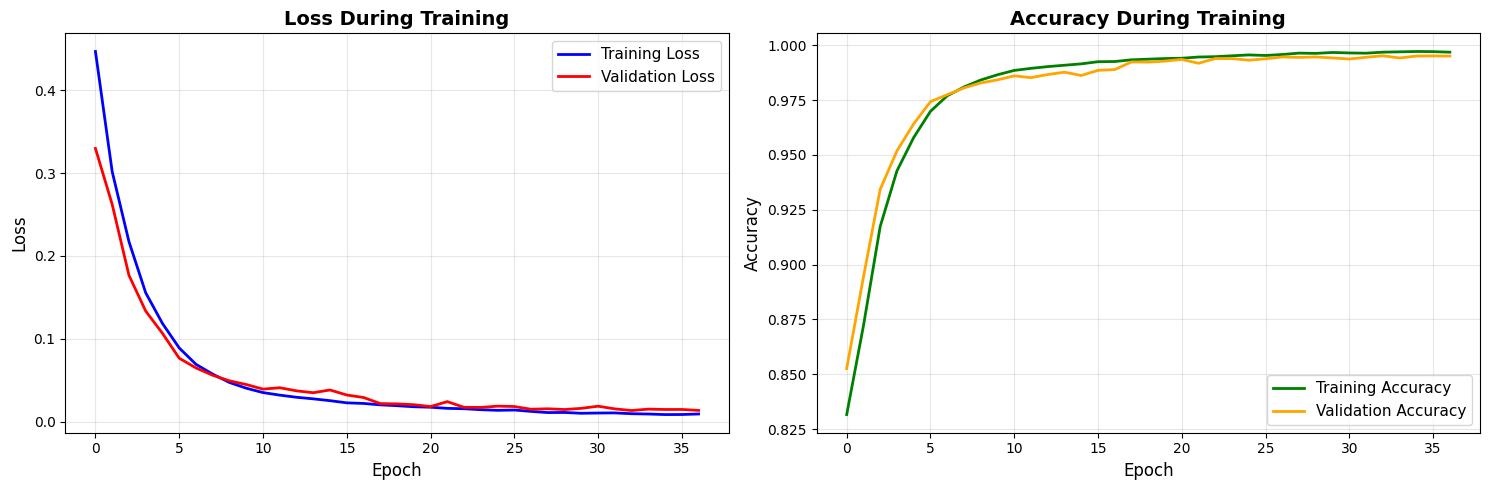


--------------------------------------------------
TRAINING SUMMARY
--------------------------------------------------
Total epochs trained: 37
Final training loss: 0.0095
Final validation loss: 0.0138
Final training accuracy: 0.9968
Final validation accuracy: 0.9950
Best validation accuracy: 0.9952

MODEL PERFORMANCE DEMONSTRATION
Testing on 10 randomly generated expressions:

Example  1:
  Input (Infix):     b
  Target (Postfix):  b
  Generated:         b
  Score: 1.000  [✓ PERFECT]

Example  2:
  Input (Infix):     ( ( c + b ) + e )
  Target (Postfix):  c b + e +
  Generated:         c b + e +
  Score: 1.000  [✓ PERFECT]

Example  3:
  Input (Infix):     ( a * b )
  Target (Postfix):  a b *
  Generated:         a b *
  Score: 1.000  [✓ PERFECT]

Example  4:
  Input (Infix):     a
  Target (Postfix):  a
  Generated:         a
  Score: 1.000  [✓ PERFECT]

Example  5:
  Input (Infix):     ( ( a / d ) / ( e / c ) )
  Target (Postfix):  a d / e c / /
  Generated:         a d / e c / /
 

In [11]:
# --- Configuration --- #
# Set to True to force retraining even if a model file exists.
FORCE_RETRAIN = True # True

model, history = None, None
if not FORCE_RETRAIN and os.path.exists(MODEL_FILE):
    print(f"\nLoading full model from {MODEL_FILE}...")
    model = models.load_model(MODEL_FILE)
    print("Model loaded successfully.")
    model.summary()
else:
    if not FORCE_RETRAIN:
        print(f"\nModel file '{MODEL_FILE}' not found. Training a new model.")
    else:
        print("\nForcing retraining of a new model.")
    # Training phase
    model, history = train_model()

# Visualize training history if training was performed
if history:
    print(f"\n{'='*60}")
    print("TRAINING HISTORY VISUALIZATION")
    print(f"{'='*60}")
    plot_training_history(history)

# Demonstrate model performance on a few examples
demonstrate_model_performance(model, num_examples=10)

# Final, formal evaluation as specified
print(f"\n{'='*60}")
print("FINAL EVALUATION")
print(f"{'='*60}")
result_mean, result_std = test(model, no=20, rounds=10)

print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"Mean Prefix Accuracy Score: {result_mean:.4f}")
print(f"Standard Deviation:         {result_std:.4f}")
print(f"Model Parameters:           {model.count_params():,}")